# Part 1: Building models with tensorflow and keras

## 1.1 The Sequential model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### When to use a Sequential model

A `Sequential` model is appropriate for **a plain stack of layers**
where each layer has **exactly one input tensor and one output tensor**.

Schematically, the following `Sequential` model:

In [ ]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
y1 = model(x)

In [ ]:
# Create 3 layers
layer1 = layers.Dense(2, activation="relu", name="layer1")
layer2 = layers.Dense(3, activation="relu", name="layer2")
layer3 = layers.Dense(4, name="layer3")

# Call layers on a test input
x = tf.ones((3, 3))
y2 = layer3(layer2(layer1(x)))

A Sequential model is **not appropriate** when:

- Your model has multiple inputs or multiple outputs
- Any of your layers has multiple inputs or multiple outputs
- You need to do layer sharing
- You want non-linear topology (e.g. a residual connection, a multi-branch
model)

You can also create a Sequential model incrementally via the `add()` method:

In [ ]:
model = keras.Sequential()
model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(3, activation="relu"))
model.add(layers.Dense(4))

Note that there's also a corresponding `pop()` method to remove layers:
a Sequential model behaves very much like a list of layers.

In [ ]:
model.pop()
print(len(model.layers))  # 2

2


Also note that the Sequential constructor accepts a `name` argument, just like
any layer or model in Keras. This is useful to annotate TensorBoard graphs
with semantically meaningful names.

In [ ]:
model = keras.Sequential(name="my_sequential")
model.add(layers.Dense(2, activation="relu", name="layer1"))
model.add(layers.Dense(3, activation="relu", name="layer2"))
model.add(layers.Dense(4, name="layer3"))

In [ ]:
model = keras.Sequential([
  layers.Dense(2, activation="relu", name="layer1", input_shape = (None,3)),
  layers.Dense(3, activation="relu", name="layer2"),
  layers.Dense(4, activation="relu", name="layer3")
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, None, 2)           8         
_________________________________________________________________
layer2 (Dense)               (None, None, 3)           9         
_________________________________________________________________
layer3 (Dense)               (None, None, 4)           16        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


### Specifying the input shape in advance

Generally, all layers in Keras need to know the shape of their inputs
in order to be able to create their weights. So when you create a layer like
this, initially, it has no weights:

In [ ]:
layer = layers.Dense(3, input_shape=(4,))
# Call layer on a test input
x = tf.ones((1, 4))
y = layer(x)
layer.weights  # Now it has weights, of shape (4, 3) and (3,)

[<tf.Variable 'dense_4/kernel:0' shape=(4, 3) dtype=float32, numpy=
 array([[-0.6963607 ,  0.6940304 ,  0.07233369],
        [ 0.81472075,  0.0911864 ,  0.7682022 ],
        [ 0.10128081,  0.02188146, -0.37670553],
        [ 0.6654526 ,  0.03616661, -0.49429274]], dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

Naturally, this also applies to Sequential models. When you instantiate a
Sequential model without an input shape, it isn't "built": it has no weights
(and calling
`model.weights` results in an error stating just this). The weights are created
when the model first sees some input data:

In [ ]:
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu"),
        layers.Dense(3, activation="relu"),
        layers.Dense(4),
    ]
)  # No weights at this stage!

# At this point, you can't do this:
# model.weights

# You also can't do this:
# model.summary()

# Call the model on a test input
x = tf.ones((1, 4))
y = model(x)
print("Number of weights after calling the model:", len(model.weights))  # 6

Number of weights after calling the model: 6


Once a model is "built", you can call its `summary()` method to display its
contents:

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (1, 2)                    10        
_________________________________________________________________
dense_6 (Dense)              (1, 3)                    9         
_________________________________________________________________
dense_7 (Dense)              (1, 4)                    16        
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


However, it can be very useful when building a Sequential model incrementally
to be able to display the summary of the model so far, including the current
output shape. In this case, you should start your model by passing an `Input`
object to your model, so that it knows its input shape from the start:

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(4,)))
model.add(layers.Dense(2, activation="relu", ))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


Note that the `Input` object is not displayed as part of `model.layers`, since
it isn't a layer:

In [ ]:
model.layers

A simple alternative is to just pass an `input_shape` argument to your first
layer:

In [ ]:
model = keras.Sequential()
model.add(layers.Dense(2, activation="relu", input_shape=(4,)))
model.add(layers.Dense(4, activation="relu"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


Models built with a predefined input shape like this always have weights (even
before seeing any data) and always have a defined output shape.

In general, it's a recommended best practice to always specify the input shape
of a Sequential model in advance if you know what it is.

## Part 1.2 Functional API

### Introduction

The Keras *functional API* is a way to create models that are more flexible
than the `tf.keras.Sequential` API. The functional API can handle models
with non-linear topology, shared layers, and even multiple inputs or outputs.

The main idea is that a deep learning model is usually
a directed acyclic graph (DAG) of layers.
So the functional API is a way to build *graphs of layers*.

Consider the following model:

```
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: logits of a probability distribution over 10 classes)
```

This is a basic graph with three layers.
To build this model using the functional API, start by creating an input node:

In [ ]:
inputs = keras.Input(shape=(784,))

The shape of the data is set as a 784-dimensional vector.
The batch size is always omitted since only the shape of each sample is specified.

If, for example, you have an image input with a shape of `(32, 32, 3)`,
you would use:

In [ ]:
# Just for demonstration purposes.
img_inputs = keras.Input(shape=(32, 32, 3))

The `inputs` that is returned contains information about the shape and `dtype`
of the input data that you feed to your model.
Here's the shape:

In [ ]:
print(inputs.shape)
print(inputs.dtype)

(None, 784)
<dtype: 'float32'>


You create a new node in the graph of layers by calling a layer on this `inputs`
object:

In [ ]:
dense = layers.Dense(64, activation="relu",trainable=False)
x = dense(inputs)

The "layer call" action is like drawing an arrow from "inputs" to this layer
you created.
You're "passing" the inputs to the `dense` layer, and you get `x` as the output.

Let's add a few more layers to the graph of layers:

In [ ]:
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

At this point, you can create a `Model` by specifying its inputs and outputs
in the graph of layers:

In [ ]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

Let's check out what the model summary looks like:

In [ ]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                650       
Total params: 55,050
Trainable params: 4,810
Non-trainable params: 50,240
_________________________________________________________________


You can also plot the model as a graph:

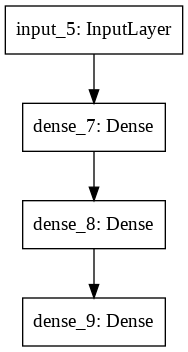

In [ ]:
keras.utils.plot_model(model, "my_first_model.png")

And, optionally, display the input and output shapes of each layer
in the plotted graph:

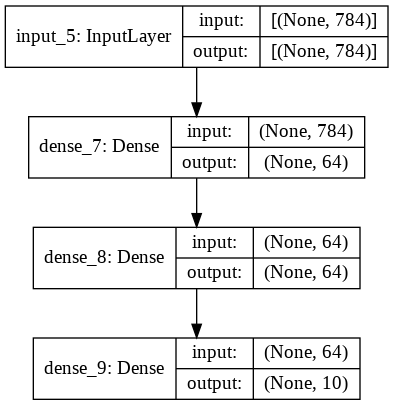

In [ ]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

Example of non linear topology

In [ ]:
inputs = keras.Input(shape=(100,))
x1 = keras.layers.Dense(50, activation='relu')(inputs)
x2 = keras.layers.Dense(50, activation='tanh')(inputs)
output = keras.layers.Concatenate()([x1, x2])
model = keras.Model(inputs, output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 50)           5050        input_4[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 50)           5050        input_4[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 100)          0           dense_16[0][0]                   
                                                                 dense_17[0][0]               

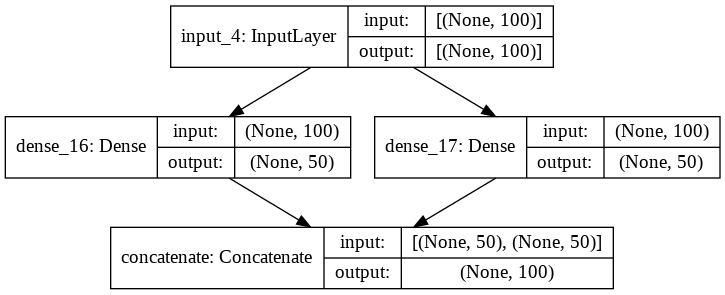

In [ ]:
keras.utils.plot_model(model, "my_second_model_with_shape_info.png", show_shapes=True)

## All models are callable, just like layers

You can treat any model as if it were a layer by invoking it on an `Input` or
on the output of another layer. By calling a model you aren't just reusing
the architecture of the model, you're also reusing its weights.

To see this in action, here's a different take on the autoencoder example that
creates an encoder model, a decoder model, and chains them in two calls
to obtain the autoencoder model:

In [ ]:
encoder_input = keras.Input(shape=(1000, ), name="original_vector")
x = layers.Dense(100, activation='relu')(encoder_input)
x = layers.Dense(20, activation='relu')(x)
encoder_output = layers.Dense(3, activation='linear')(x)
encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(3,), name="decoded_vector")
x = layers.Dense(20, activation='relu')(decoder_input)
x = layers.Dense(100, activation='relu')(x)
decoder_output = layers.Dense(1000, activation='relu')(x)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(1000,), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_vector (InputLayer) [(None, 1000)]            0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               100100    
_________________________________________________________________
dense_19 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 63        
Total params: 102,183
Trainable params: 102,183
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoded_vector (InputLayer)  [(None, 3)]               0         
____________________________________

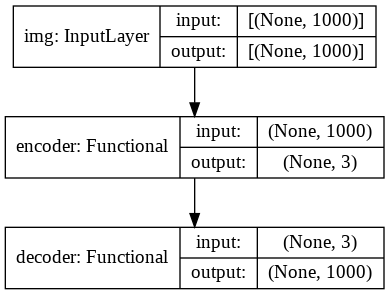

In [ ]:
keras.utils.plot_model(autoencoder, "my_first_autoencoder_with_shape_info.png", show_shapes=True)

As you can see, the model can be nested: a model can contain sub-models
(since a model is just like a layer).
A common use case for model nesting is *ensembling*.
For example, here's how to ensemble a set of models into a single model
that averages their predictions:

In [ ]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

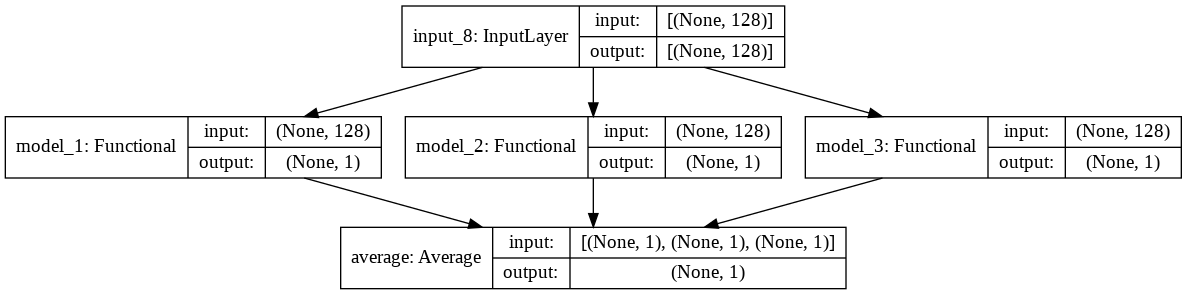

In [ ]:
keras.utils.plot_model(ensemble_model, "my_first_ensemble_with_shape_info.png", show_shapes=True)

## Extend the API using custom layers

`tf.keras` includes a wide range of built-in layers, for example:

- Convolutional layers: `Conv1D`, `Conv2D`, `Conv3D`, `Conv2DTranspose`
- Pooling layers: `MaxPooling1D`, `MaxPooling2D`, `MaxPooling3D`, `AveragePooling1D`
- RNN layers: `GRU`, `LSTM`, `ConvLSTM2D`
- `BatchNormalization`, `Dropout`, `Embedding`, etc.

But if you don't find what you need, it's easy to extend the API by creating
your own layers. All layers subclass the `Layer` class and implement:

- `call` method, that specifies the computation done by the layer.
- `build` method, that creates the weights of the layer (this is just a style
convention since you can create weights in `__init__`, as well).

To learn more about creating layers from scratch, read
[custom layers and models](https://www.tensorflow.org/guide/keras/custom_layers_and_models) guide.

The following is a basic implementation of `tf.keras.layers.Dense`:

In [ ]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)

## Part 1.3 Making new Layers and Models via subclassing

## The `Layer` class: the combination of state (weights) and some computation

One of the central abstraction in Keras is the `Layer` class. A layer
encapsulates both a state (the layer's "weights") and a transformation from
inputs to outputs (a "call", the layer's forward pass).

Here's a densely-connected layer. It has a state: the variables `w` and `b`.

In [ ]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(units,), dtype="float32"), trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


In [ ]:
x = tf.ones((2, 2))
linear_layer = Linear(4, 2)
y = linear_layer(x)
print(y)

tf.Tensor(
[[-0.16945307  0.1262916   0.02342755  0.10556003]
 [-0.16945307  0.1262916   0.02342755  0.10556003]], shape=(2, 4), dtype=float32)


Note that the weights `w` and `b` are automatically tracked by the layer upon
being set as layer attributes:

In [ ]:
assert linear_layer.weights == [linear_layer.w, linear_layer.b]

In [ ]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        self.w = self.add_weight(
            shape=(input_dim, units), initializer="random_normal", trainable=True
        )
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


x = tf.ones((2, 2))
linear_layer = Linear(4, 2)
y = linear_layer(x)
print(y)

tf.Tensor(
[[ 0.15844831 -0.05695023 -0.08595693 -0.01482543]
 [ 0.15844831 -0.05695023 -0.08595693 -0.01482543]], shape=(2, 4), dtype=float32)


## Layers can have non-trainable weights

Besides trainable weights, you can add non-trainable weights to a layer as
well. Such weights are meant not to be taken into account during
backpropagation, when you are training the layer.

Here's how to add and use a non-trainable weight:

In [ ]:
class ComputeSum(keras.layers.Layer):
    def __init__(self, input_dim):
        super(ComputeSum, self).__init__()
        self.total = tf.Variable(initial_value=tf.zeros((input_dim,)), trainable=False)

    def call(self, inputs):
        self.total.assign_add(tf.reduce_sum(inputs, axis=0))
        return self.total


x = tf.ones((2, 2))
my_sum = ComputeSum(2)
y = my_sum(x)
print(y.numpy())
y = my_sum(x)
print(y.numpy())

[2. 2.]
[4. 4.]


It's part of `layer.weights`, but it gets categorized as a non-trainable weight:

In [ ]:
print("weights:", len(my_sum.weights))
print("non-trainable weights:", len(my_sum.non_trainable_weights))
print("non-trainable weights:", len(my_sum.trainable_weights))

# It's not included in the trainable weights:
print("trainable_weights:", my_sum.trainable_weights)

weights: 1
non-trainable weights: 1
non-trainable weights: 0
trainable_weights: []


### Best practice: deferring weight creation until the shape of the inputs is known

Our `Linear` layer above took an `input_dim `argument that was used to compute
the shape of the weights `w` and `b` in `__init__()`:

In [ ]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        self.w = self.add_weight(
            shape=(input_dim, units), initializer="random_normal", trainable=True
        )
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


In many cases, you may not know in advance the size of your inputs, and you
would like to lazily create weights when that value becomes known, some time
after instantiating the layer.

In the Keras API, we recommend creating layer weights in the `build(self,
inputs_shape)` method of your layer. Like this:

In [ ]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


The `__call__()` method of your layer will automatically run build the first time
it is called. You now have a layer that's lazy and thus easier to use:

In [ ]:
# At instantiation, we don't know on what inputs this is going to get called
linear_layer = Linear(32)

# The layer's weights are created dynamically the first time the layer is called
y = linear_layer(x)

## Layers are recursively composable

If you assign a Layer instance as an attribute of another Layer, the outer layer
will start tracking the weights of the inner layer.

We recommend creating such sublayers in the `__init__()` method (since the
sublayers will typically have a build method, they will be built when the
outer layer gets built).

In [ ]:
# Let's assume we are reusing the Linear class
# with a `build` method that we defined above.


class MLPBlock(keras.layers.Layer):
    def __init__(self):
        super(MLPBlock, self).__init__()
        self.linear_1 = Linear(32)
        self.linear_2 = Linear(32)
        self.linear_3 = Linear(1)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)


mlp = MLPBlock()
y = mlp(tf.ones(shape=(3, 64)))  # The first call to the `mlp` will create the weights
print("weights:", len(mlp.weights))
print("trainable weights:", len(mlp.trainable_weights))

weights: 6
trainable weights: 6


## The `add_loss()` method

When writing the `call()` method of a layer, you can create loss tensors that
you will want to use later, when writing your training loop. This is doable by
calling `self.add_loss(value)`:

In [ ]:
# A layer that creates an activity regularization loss
class ActivityRegularizationLayer(keras.layers.Layer):
    def __init__(self, rate=1e-2):
        super(ActivityRegularizationLayer, self).__init__()
        self.rate = rate

    def call(self, inputs):
        self.add_loss(self.rate * tf.reduce_sum(inputs))
        return inputs


These losses (including those created by any inner layer) can be retrieved via
`layer.losses`. This property is reset at the start of every `__call__()` to
the top-level layer, so that `layer.losses` always contains the loss values
created during the last forward pass.

In [ ]:
class OuterLayer(keras.layers.Layer):
    def __init__(self):
        super(OuterLayer, self).__init__()
        self.activity_reg = ActivityRegularizationLayer(1e-2)

    def call(self, inputs):
        return self.activity_reg(inputs)


layer = OuterLayer()
assert len(layer.losses) == 0  # No losses yet since the layer has never been called

_ = layer(tf.zeros(1, 1))
assert len(layer.losses) == 1  # We created one loss value

# `layer.losses` gets reset at the start of each __call__
_ = layer(tf.zeros(1, 1))
assert len(layer.losses) == 1  # This is the loss created during the call above

In addition, the `loss` property also contains regularization losses created
for the weights of any inner layer:

In [ ]:
class OuterLayerWithKernelRegularizer(keras.layers.Layer):
    def __init__(self):
        super(OuterLayerWithKernelRegularizer, self).__init__()
        self.dense = keras.layers.Dense(
            32, kernel_regularizer=tf.keras.regularizers.l2(1e-3)
        )

    def call(self, inputs):
        return self.dense(inputs)


layer = OuterLayerWithKernelRegularizer()
_ = layer(tf.zeros((1, 1)))

# This is `1e-3 * sum(layer.dense.kernel ** 2)`,
# created by the `kernel_regularizer` above.
print(layer.losses)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.0017797637>]


These losses are meant to be taken into account when writing training loops,
like this:

```python
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Iterate over the batches of a dataset.
for x_batch_train, y_batch_train in train_dataset:
  with tf.GradientTape() as tape:
    logits = layer(x_batch_train)  # Logits for this minibatch
    # Loss value for this minibatch
    loss_value = loss_fn(y_batch_train, logits)
    # Add extra losses created during this forward pass:
    loss_value += sum(model.losses)

  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
```

For a detailed guide about writing training loops, see the
[guide to writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/).

These losses also work seamlessly with `fit()` (they get automatically summed
and added to the main loss, if any):

## The `add_metric()` method

Similarly to `add_loss()`, layers also have an `add_metric()` method
for tracking the moving average of a quantity during training.

Consider the following layer: a "logistic endpoint" layer.
It takes as inputs predictions & targets, it computes a loss which it tracks
via `add_loss()`, and it computes an accuracy scalar, which it tracks via
`add_metric()`.

In [ ]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)


Metrics tracked in this way are accessible via `layer.metrics`:

In [ ]:
layer = LogisticEndpoint()

targets = tf.ones((2, 2))
logits = tf.ones((2, 2))
y = layer(targets, logits)

print("layer.metrics:", layer.metrics)
print("current accuracy value:", float(layer.metrics[0].result()))

layer.metrics: [<keras.metrics.BinaryAccuracy object at 0x7f6e10115fd0>]
current accuracy value: 1.0


Just like for `add_loss()`, these metrics are tracked by `fit()`:

In [ ]:
import numpy as np
inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - 0s 453ms/step - loss: 1.0537 - binary_accuracy: 0.0000e+00


## Privileged `training` argument in the `call()` method

Some layers, in particular the `BatchNormalization` layer and the `Dropout`
layer, have different behaviors during training and inference. For such
layers, it is standard practice to expose a `training` (boolean) argument in
the `call()` method.

By exposing this argument in `call()`, you enable the built-in training and
evaluation loops (e.g. `fit()`) to correctly use the layer in training and
inference.

In [ ]:
class CustomDropout(keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super(CustomDropout, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs


## The `Model` class

In general, you will use the `Layer` class to define inner computation blocks,
and will use the `Model` class to define the outer model -- the object you
will train.

For instance, in a ResNet50 model, you would have several ResNet blocks
subclassing `Layer`, and a single `Model` encompassing the entire ResNet50
network.

The `Model` class has the same API as `Layer`, with the following differences:

- It exposes built-in training, evaluation, and prediction loops
(`model.fit()`, `model.evaluate()`, `model.predict()`).
- It exposes the list of its inner layers, via the `model.layers` property.
- It exposes saving and serialization APIs (`save()`, `save_weights()`...)

Effectively, the `Layer` class corresponds to what we refer to in the
literature as a "layer" (as in "convolution layer" or "recurrent layer") or as
a "block" (as in "ResNet block" or "Inception block").

Meanwhile, the `Model` class corresponds to what is referred to in the
literature as a "model" (as in "deep learning model") or as a "network" (as in
"deep neural network").

So if you're wondering, "should I use the `Layer` class or the `Model` class?",
ask yourself: will I need to call `fit()` on it? Will I need to call `save()`
on it? If so, go with `Model`. If not (either because your class is just a block
in a bigger system, or because you are writing training & saving code yourself),
use `Layer`.

For instance, we could take our mini-resnet example above, and use it to build
a `Model` that we could train with `fit()`, and that we could save with
`save_weights()`:

```python
class ResNet(tf.keras.Model):

    def __init__(self, num_classes=1000):
        super(ResNet, self).__init__()
        self.block_1 = ResNetBlock()
        self.block_2 = ResNetBlock()
        self.global_pool = layers.GlobalAveragePooling2D()
        self.classifier = Dense(num_classes)

    def call(self, inputs):
        x = self.block_1(inputs)
        x = self.block_2(x)
        x = self.global_pool(x)
        return self.classifier(x)


resnet = ResNet()
dataset = ...
resnet.fit(dataset, epochs=10)
resnet.save(filepath)
```

# Part 2: MNIST Digit Classification

In the first portion of this lab, we will build and train a convolutional neural network (CNN) for classification of handwritten digits from the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The MNIST dataset consists of 60,000 training images and 10,000 test images. Our classes are the digits 0-9.

First, let's download the course repository, install dependencies, and import the relevant packages we'll need for this lab.

In [ ]:
# Import Tensorflow 2.0
# %tensorflow_version 2.x
import os

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# # Check that we are using a GPU, if not switch runtimes
# #   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)

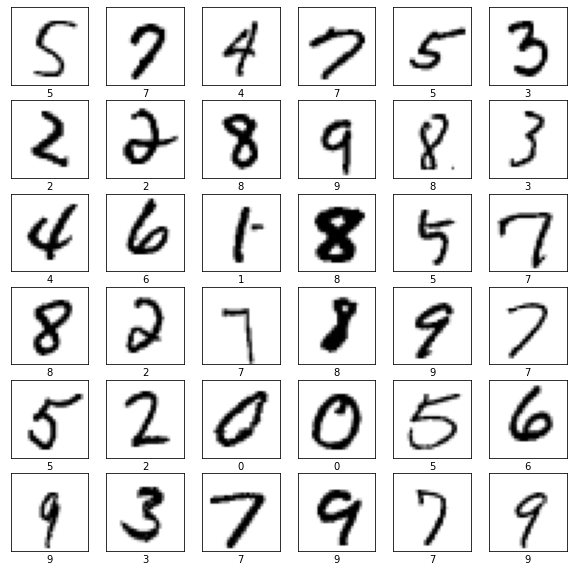

In [ ]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])

## 1.2 Neural Network for Handwritten Digit Classification

We'll first build a simple neural network consisting of two fully connected layers and apply this to the digit classification task. Our network will ultimately output a probability distribution over the 10 digit classes (0-9). This first architecture we will be building is depicted below:

![alt_text](https://raw.githubusercontent.com/aamini/introtodeeplearning/master/lab2/img/mnist_2layers_arch.png "CNN Architecture for MNIST Classification")


### Fully connected neural network architecture
To define the architecture of this first fully connected neural network, we'll once again use the Keras API and define the model using the [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential) class. Note how we first use a [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) layer, which flattens the input so that it can be fed into the model.

In this next block, you'll define the fully connected layers of this simple work.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_31 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


As we progress through this next portion, you may find that you'll want to make changes to the architecture defined above. **Note that in order to update the model later on, you'll need to re-run the above cell to re-initialize the model.**

Let's take a step back and think about the network we've just created. The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a 2d-array (28 x 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. You can think of this layer as unstacking rows of pixels in the image and lining them up. There are no learned parameters in this layer; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are fully-connected neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer (which you've defined!) should return an array of probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the handwritten digit classes.

That defines our fully connected model!



### Compile the model

Before training the model, we need to define a few more settings. These are added during the model's [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#compile) step:

* *Loss function* — This defines how we measure how accurate the model is during training. As was covered in lecture, during training we want to minimize this function, which will "steer" the model in the right direction.
* *Optimizer* — This defines how the model is updated based on the data it sees and its loss function.
* *Metrics* — Here we can define metrics used to monitor the training and testing steps. In this example, we'll look at the *accuracy*, the fraction of the images that are correctly classified.

We'll start out by using a stochastic gradient descent (SGD) optimizer initialized with a learning rate of 0.1. Since we are performing a categorical classification task, we'll want to use the [cross entropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/sparse_categorical_crossentropy).

You'll want to experiment with both the choice of optimizer and learning rate and evaluate how these affect the accuracy of the trained model.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

We're now ready to train our model, which will involve feeding the training data (`train_images` and `train_labels`) into the model, and then asking it to learn the associations between images and labels. We'll also need to define the batch size and the number of epochs, or iterations over the MNIST dataset, to use during training.

In Lab 1, we saw how we can use `GradientTape` to optimize losses and train models with stochastic gradient descent. After defining the model settings in the `compile` step, we can also accomplish training by calling the [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#fit) method on an instance of the `Model` class. We will use this to train our fully connected model


In [ ]:
BATCH_SIZE = 64
EPOCHS = 20

model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/20
938/938 [==============================] - 3s 3ms/step - loss: 0.8518 - accuracy: 0.7997
Epoch 2/20
938/938 [==============================] - 2s 3ms/step - loss: 0.4116 - accuracy: 0.8901
Epoch 3/20
938/938 [==============================] - 2s 3ms/step - loss: 0.3473 - accuracy: 0.9038
Epoch 4/20
938/938 [==============================] - 2s 3ms/step - loss: 0.3143 - accuracy: 0.9119
Epoch 5/20
938/938 [==============================] - 2s 3ms/step - loss: 0.2918 - accuracy: 0.9179
Epoch 6/20
938/938 [==============================] - 2s 3ms/step - loss: 0.2747 - accuracy: 0.9230
Epoch 7/20
938/938 [==============================] - 2s 3ms/step - loss: 0.2607 - accuracy: 0.9265
Epoch 8/20
938/938 [==============================] - 2s 3ms/step - loss: 0.2487 - accuracy: 0.9305
Epoch 9/20
938/938 [==============================] - 2s 3ms/step - loss: 0.2380 - accuracy: 0.9337
Epoch 10/20
938/938 [==============================] - 2s 3ms/step - loss: 0.2284 - accuracy: 0.9363

As the model trains, the loss and accuracy metrics are displayed. With five epochs and a learning rate of 0.01, this fully connected model should achieve an accuracy of approximatley 0.97 (or 97%) on the training data.

### Evaluate accuracy on the test dataset

Now that we've trained the model, we can ask it to make predictions about a test set that it hasn't seen before. In this example, the `test_images` array comprises our test dataset. To evaluate accuracy, we can check to see if the model's predictions match the labels from the `test_labels` array.

Use the [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate) method to evaluate the model on the test dataset!

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.1612 - accuracy: 0.9519
Test accuracy: 0.9519000053405762


## 1.3 Convolutional Neural Network (CNN) for handwritten digit classification

As we saw in lecture, convolutional neural networks (CNNs) are particularly well-suited for a variety of tasks in computer vision, and have achieved near-perfect accuracies on the MNIST dataset. We will now build a CNN composed of two convolutional layers and pooling layers, followed by two fully connected layers, and ultimately output a probability distribution over the 10 digit classes (0-9). The CNN we will be building is depicted below:

![alt_text](https://raw.githubusercontent.com/aamini/introtodeeplearning/master/lab2/img/convnet_fig.png "CNN Architecture for MNIST Classification")

### Define the CNN model

We'll use the same training and test datasets as before, and proceed similarly as our fully connected network to define and train our new CNN model. To do this we will explore two layers we have not encountered before: you can use  [`keras.layers.Conv2D` ](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) to define convolutional layers and [`keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) to define the pooling layers. Use the parameters shown in the network architecture above to define these layers and build the CNN model.

In [ ]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([

        layers.Conv2D(24, (3, 3), activation='relu'),
        layers.MaxPool2D((2, 2)),
        layers.Conv2D(36, (3, 3)),
        layers.MaxPool2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax'),
    ])

    return cnn_model

cnn_model = build_cnn_model()
# Initialize the model by passing some data through
cnn_model.predict(train_images[[0]])
# Print the summary of the layers in the model.
print(cnn_model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 24)        240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 36)        7812      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               115328    
_________________________________________________________________
dense_33 (Dense)             (None, 10)               

### Train and test the CNN model

Now, as before, we can define the loss function, optimizer, and metrics through the `compile` method. Compile the CNN model with an optimizer and learning rate of choice:

In [ ]:
cnn_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

As was the case with the fully connected model, we can train our CNN using the `fit` method via the Keras API.

In [ ]:
BATCH_SIZE = 64
EPOCHS = 5

cnn_model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0902 - accuracy: 0.9727
Epoch 2/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0810 - accuracy: 0.9754
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0729 - accuracy: 0.9782
Epoch 4/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0661 - accuracy: 0.9802
Epoch 5/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0609 - accuracy: 0.9816


Great! Now that we've trained the model, let's evaluate it on the test dataset using the [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate) method:

In [ ]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0602 - accuracy: 0.9815
Test accuracy: 0.9815000295639038


What is the highest accuracy you're able to achieve using the CNN model, and how does the accuracy of the CNN model compare to the accuracy of the simple fully connected network? What optimizers and learning rates seem to be optimal for training the CNN model?

### Make predictions with the CNN model

With the model trained, we can use it to make predictions about some images. The [`predict`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#predict) function call generates the output predictions given a set of input samples.


In [ ]:
predictions = cnn_model.predict(test_images)

In [ ]:
predictions

array([[2.4115562e-07, 1.2066565e-07, 2.3860310e-05, ..., 9.9995720e-01,
        1.5485568e-08, 6.5467736e-07],
       [1.1623656e-05, 7.6289180e-05, 9.9989939e-01, ..., 2.7285061e-11,
        2.3177977e-06, 9.3983252e-13],
       [4.4251079e-05, 9.9666023e-01, 3.6694581e-04, ..., 1.8520736e-03,
        2.7535256e-04, 1.5207073e-05],
       ...,
       [7.2960562e-09, 3.5555070e-10, 8.4662005e-10, ..., 8.0175123e-06,
        1.9094989e-07, 1.5570504e-06],
       [1.7870582e-06, 1.2661020e-07, 1.8392640e-07, ..., 4.4842867e-08,
        1.5384397e-03, 7.9377209e-08],
       [1.8150469e-07, 2.1394844e-09, 9.2512494e-08, ..., 7.6121444e-13,
        5.5094498e-09, 5.9376865e-11]], dtype=float32)

With this function call, the model has predicted the label for each image in the testing set. Let's take a look at the prediction for the first image in the test dataset:

In [ ]:
predictions[0]

array([2.4115562e-07, 1.2066565e-07, 2.3860310e-05, 1.7745770e-05,
       1.5837279e-10, 6.4552133e-08, 5.8127422e-12, 9.9995720e-01,
       1.5485568e-08, 6.5467736e-07], dtype=float32)

As you can see, a prediction is an array of 10 numbers. Recall that the output of our model is a probability distribution over the 10 digit classes. Thus, these numbers describe the model's "confidence" that the image corresponds to each of the 10 different digits.

Let's look at the digit that has the highest confidence for the first image in the test dataset:

In [ ]:
'''TODO: identify the digit with the highest confidence prediction for the first
    image in the test dataset. '''
prediction = np.argmax(predictions, axis=1)

print(prediction)

[7 2 1 ... 4 5 6]


In [ ]:
test_labels

array([7, 2, 1, ..., 4, 5, 6])

So, the model is most confident that this image is a "???". We can check the test label (remember, this is the true identity of the digit) to see if this prediction is correct:

Label of this digit is: 7


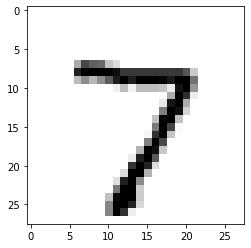

In [ ]:
print("Label of this digit is:", test_labels[0])
plt.imshow(test_images[0,:,:,0], cmap=plt.cm.binary)

We can also plot several images along with their predictions, where correct prediction labels are blue and incorrect prediction labels are grey. The number gives the percent confidence (out of 100) for the predicted label. Note the model can be very confident in an incorrect prediction!